In [35]:
import json
import numpy as np
from gensim.models import KeyedVectors
import random

In [36]:
model = KeyedVectors.load("wiktionary5800_custom.kv")

with open("korean_frequency.json", encoding="utf-8") as f:
    data = json.load(f)

In [37]:
word_list = sorted({w for group in data.values() for w in group if w in model})


In [38]:
def update_candidates(candidates, guess, similarity, tolerance=5.0):
    new_candidates = []
    for cand in candidates:
        if cand in model and guess in model:
            sim = model.similarity(cand, guess) * 100
            if abs(sim - similarity) <= tolerance:
                new_candidates.append(cand)
    return new_candidates

def select_best_guess(candidates, tried):
    max_entropy = -1
    best_word = None
    for word in candidates:
        if word not in model:
            continue
        sims = []
        for other in tried:
            if other in model:
                sims.append(model.similarity(word, other))
        entropy = -np.sum(np.log(np.clip(sims, 1e-5, 1))) if sims else 0
        if entropy > max_entropy:
            max_entropy = entropy
            best_word = word
    return best_word or random.choice(candidates)

In [51]:
def simulate_game(answer, verbose=True, max_steps=100):
    if answer not in model:
        raise ValueError(f"정답 '{answer}'이(가) 모델에 없습니다.")

    candidates = word_list.copy()
    tried = []

    for step in range(1, max_steps + 1):
        guess = select_best_guess(candidates, tried)
        tried.append(guess)

        if guess == answer:
            if verbose:
                print(f"✅ 정답 '{guess}'을 {step}번 만에 맞췄습니다!")
            return tried

        similarity = model.similarity(guess, answer) * 100
        if verbose:
            print(f"{step}. '{guess}' → 유사도: {similarity:.2f}")

        candidates = update_candidates(candidates, guess, similarity)

    if verbose:
        print(f"❌ 실패: {max_steps}회 이내에 정답을 못 맞힘")
    return tried

In [52]:
simulate_game("사랑스럽다", max_steps=100)

1. '가게' → 유사도: 77.55
2. '발걸음' → 유사도: 84.91
3. '꿈속' → 유사도: 78.08
4. '바깥' → 유사도: 79.91
5. '운동화' → 유사도: 81.25
6. '묶다' → 유사도: 86.08
7. '전문직' → 유사도: 86.77
8. '어머님' → 유사도: 85.95
9. '꾸미다' → 유사도: 84.91
10. '인형' → 유사도: 91.21
11. '소시지' → 유사도: 86.95
12. '과외' → 유사도: 88.55
13. '쓰이다' → 유사도: 86.47
14. '반갑다' → 유사도: 92.62
15. '되돌리다' → 유사도: 92.70
16. '바깥쪽' → 유사도: 93.08
17. '신세' → 유사도: 93.12
18. '쩔쩔매다' → 유사도: 93.48
19. '독특하다' → 유사도: 93.46
20. '양배추' → 유사도: 94.96
21. '부러지다' → 유사도: 94.63
✅ 정답 '사랑스럽다'을 22번 만에 맞췄습니다!


['가게',
 '발걸음',
 '꿈속',
 '바깥',
 '운동화',
 '묶다',
 '전문직',
 '어머님',
 '꾸미다',
 '인형',
 '소시지',
 '과외',
 '쓰이다',
 '반갑다',
 '되돌리다',
 '바깥쪽',
 '신세',
 '쩔쩔매다',
 '독특하다',
 '양배추',
 '부러지다',
 '사랑스럽다']

In [67]:
# 전체 성능 평가
import pandas as pd
def evaluate_model(sample_size=20):
    valid_words = [w for w in word_list if w in model]
    sampled_answers = [
    '넉넉하다', '익히다', '녹색', '운전자', '오랫동안',
    '소프트웨어', '광고', '찾아오다', '흥분하다', '도심',
    '이제야', '끊다', '실정', '월급', '발견',
    '기운', '교육', '빌다', '신선하다', '끝나다',
    '이야기', '기록', '그릇', '대답', '출근'
]

    results = []
    for ans in sampled_answers:
        tried = simulate_game(ans)
        found = tried[-1] == ans
        results.append({
            'answer': ans,
            'steps': len(tried),
            'success': found
        })

    return pd.DataFrame(results)

1. '가게' → 유사도: 72.22
2. '어렵다' → 유사도: 59.69
3. '인도' → 유사도: 69.20
4. '피망' → 유사도: 84.95
5. '앉히다' → 유사도: 75.83
6. '스케줄' → 유사도: 88.35
7. '점심시간' → 유사도: 84.01
8. '구경' → 유사도: 86.58
9. '심각해지다' → 유사도: 85.85
10. '레몬' → 유사도: 88.36
11. '냉동' → 유사도: 90.11
✅ 정답 '넉넉하다'을 12번 만에 맞췄습니다!
1. '가게' → 유사도: 70.07
2. '일식' → 유사도: 72.41
3. '미사일' → 유사도: 56.22
4. '겨울' → 유사도: 87.02
5. '소녀' → 유사도: 77.23
6. '되돌아보다' → 유사도: 87.42
7. '붙들다' → 유사도: 88.89
8. '짚다' → 유사도: 90.32
✅ 정답 '익히다'을 9번 만에 맞췄습니다!
1. '가게' → 유사도: 61.46
2. '화분' → 유사도: 79.22
3. '개다' → 유사도: 75.09
4. '장식' → 유사도: 75.32
5. '여가' → 유사도: 91.07
6. '독서' → 유사도: 86.68
✅ 정답 '녹색'을 7번 만에 맞췄습니다!
1. '가게' → 유사도: 77.66
2. '끄다' → 유사도: 59.45
3. '입히다' → 유사도: 44.04
4. '부인' → 유사도: 64.31
✅ 정답 '운전자'을 5번 만에 맞췄습니다!
1. '가게' → 유사도: 59.93
2. '가상' → 유사도: 44.58
3. '훌륭하다' → 유사도: 75.81
4. '튼튼하다' → 유사도: 65.67
5. '청바지' → 유사도: 77.48
✅ 정답 '오랫동안'을 6번 만에 맞췄습니다!
1. '가게' → 유사도: 65.13
2. '연말' → 유사도: 78.42
3. '올여름' → 유사도: 70.28
4. '여행사' → 유사도: 90.73
5. '청소기' → 유사도: 92.49
6. '기기' → 유사도: 87.99
7. '코스모스'

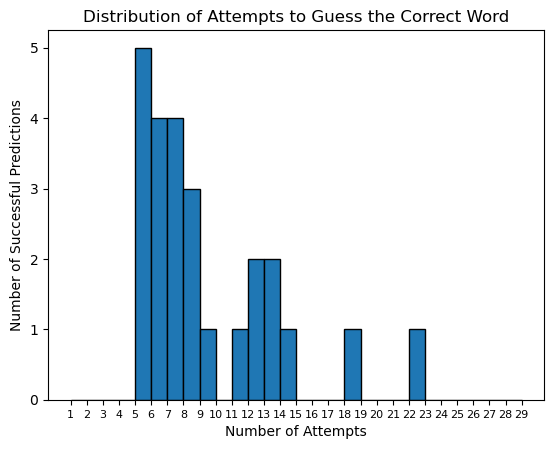

Average Number of Attempts: 9.00
Success Rate: 100.0%


In [70]:
# 평가 및 시각화
import matplotlib.pyplot as plt

df = evaluate_model(30)

plt.figure()
plt.hist(df['steps'], bins=range(1, 30), edgecolor='black')
plt.xticks(np.arange(1, 30, 1), fontsize=8)
plt.xlabel("Number of Attempts")
plt.ylabel("Number of Successful Predictions")
plt.title("Distribution of Attempts to Guess the Correct Word")
plt.show()

avg_steps = df['steps'].mean()
success_rate = df['success'].mean() * 100
print(f"Average Number of Attempts: {avg_steps:.2f}")
print(f"Success Rate: {success_rate:.1f}%")